# Hard Drive Stats  in Backblaze’s data centers

https://www.backblaze.com/b2/hard-drive-test-data.html

Посмотрим на статистику смартов за 2018-05-09.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

raw_stat = pd.read_csv('./data/2018-05-09.csv.zip')

In [2]:
print (raw_stat.shape)

(99836, 109)


The columns are as follows:

- **Date** – The date of the file in yyyy-mm-dd format.
- **Serial Number** – The manufacturer-assigned serial number of the drive.
- **Model** – The manufacturer-assigned model number of the drive.
- **Capacity** – The drive capacity in bytes.
- **Failure** – Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.
- **SMART Stats** – 104 columns of data, that are the Raw and Normalized values for 52 different SMART stats as reported by the given drive. Each value is the number reported by the drive.

https://www.backblaze.com/b2/hard-drive-test-data.html

**The following five SMART stats as a means of helping determine if a drive is going to fail.**

Attribute 		Description

- SMART 5 		Reallocated Sectors Count
- SMART 187 		Reported Uncorrectable Errors
- SMART 188 		Command Timeout
- SMART 197 		Current Pending Sector Count
- SMART 198 		Uncorrectable Sector Count

When the RAW value for one of these five attributes is greater than zero, we have a reason to investigate

https://www.backblaze.com/blog/hard-drive-smart-stats/

Исходя из вышесказанного, выберем только эти 5-ть значимых аттрибутов из всех имеющихся.

In [3]:
base_stat = raw_stat.loc[:, ['model', 'serial_number', 'capacity_bytes', 'failure',
                             'smart_5_raw', 'smart_187_raw',
                             'smart_188_raw', 'smart_197_raw',
                             'smart_198_raw']]

base_stat.rename(columns={'smart_5_raw': 'SMART_5',
                          'smart_187_raw': 'SMART_187',
                          'smart_188_raw': 'SMART_188',
                          'smart_197_raw': 'SMART_197',
                          'smart_198_raw': 'SMART_198'}, inplace=True)
base_stat.fillna(0, inplace=True)
base_stat.head()

,model,serial_number,capacity_bytes,failure,SMART_5,SMART_187,SMART_188,SMART_197,SMART_198
0,ST4000DM000,Z305B2QN,4000787030016,0,0,0.0,0.0,0,0
1,HGST HMS5C4040ALE640,PL1331LAHG1S4H,4000787030016,0,0,0.0,0.0,0,0
2,ST8000NM0055,ZA16NQJR,8001563222016,0,0,0.0,0.0,0,0
3,ST8000NM0055,ZA18CEBT,8001563222016,0,0,0.0,0.0,0,0
4,ST8000NM0055,ZA18CEBS,8001563222016,0,0,0.0,0.0,0,0


Посмотрим на зависимости количества дисков от определенного, отличного от нуля, смарт аттрибута. 

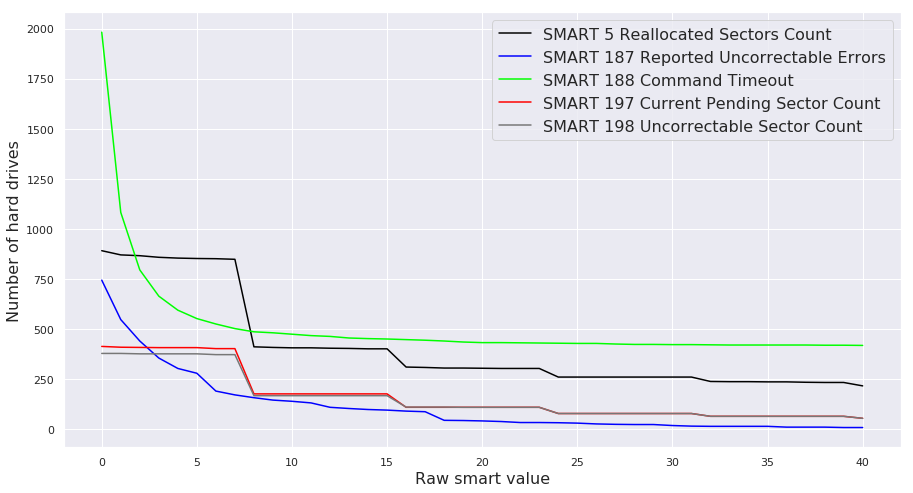

In [4]:
smart_value = np.arange(0, 41)

smart_5   = [len(base_stat.loc[base_stat.SMART_5   > v, :]) for v in smart_value]
smart_187 = [len(base_stat.loc[base_stat.SMART_187 > v, :]) for v in smart_value]
smart_188 = [len(base_stat.loc[base_stat.SMART_188 > v, :]) for v in smart_value]
smart_197 = [len(base_stat.loc[base_stat.SMART_197 > v, :]) for v in smart_value]
smart_198 = [len(base_stat.loc[base_stat.SMART_198 > v, :]) for v in smart_value]

plt.figure(figsize=(15, 8))
plt.xlabel('Raw smart value', fontsize=16)
plt.ylabel('Number of hard drives', fontsize=16)
plt.plot(smart_5,   '#000000',
         smart_187, '#0000ff',
         smart_188, '#00ff00',
         smart_197, '#ff0000',
         smart_198, '#777777')
plt.legend(['SMART 5 Reallocated Sectors Count',
            'SMART 187 Reported Uncorrectable Errors',
            'SMART 188 Command Timeout',
            'SMART 197 Current Pending Sector Count',
            'SMART 198 Uncorrectable Sector Count'], fontsize=16)

По форме графиков можно предположить, что аттрибуты: 5, 197, 198 (черный, красный и серый цвет соответственно) - взаимозависимы; 197 и 198 практически идентичны. Поэтому исключим аттрибут 198 из дальнейших исследований.

In [5]:
base_stat.drop(['SMART_198'], axis=1, inplace=True)
base_stat.head()

,model,serial_number,capacity_bytes,failure,SMART_5,SMART_187,SMART_188,SMART_197
0,ST4000DM000,Z305B2QN,4000787030016,0,0,0.0,0.0,0
1,HGST HMS5C4040ALE640,PL1331LAHG1S4H,4000787030016,0,0,0.0,0.0,0
2,ST8000NM0055,ZA16NQJR,8001563222016,0,0,0.0,0.0,0
3,ST8000NM0055,ZA18CEBT,8001563222016,0,0,0.0,0.0,0
4,ST8000NM0055,ZA18CEBS,8001563222016,0,0,0.0,0.0,0


In [6]:
print(base_stat.shape)

(99836, 8)


Посмотрим на количество жестких дисков вышедших из строя в этот день и их процент от общего числа.

In [7]:
failure_stat = base_stat.loc[base_stat.failure != 0, :]
total_disks = len(base_stat)
falure_disks = len(failure_stat)
failure_disk_percent = falure_disks / total_disks * 100.0
falure_disks, failure_disk_percent

(6, 0.006009856164109139)

Посмотрим более конкретно, какие именно диски вышли из строя и статистику их смартов на этот день.

In [8]:
failure_stat.reset_index(drop=True, inplace=True)
failure_stat

,model,serial_number,capacity_bytes,failure,SMART_5,SMART_187,SMART_188,SMART_197
0,ST4000DM000,Z3040LRE,4000787030016,1,0,2.0,0.000000e+00,224
1,ST12000NM0007,ZCH07AT8,12000138625024,1,32,0.0,1.718013e+10,0
2,ST12000NM0007,ZCH083DQ,12000138625024,1,28304,71.0,0.000000e+00,0
3,ST12000NM0007,ZJV00CZL,12000138625024,1,0,0.0,0.000000e+00,0
4,ST4000DM000,S301GQWN,4000787030016,1,8,11.0,0.000000e+00,24
5,ST4000DM000,Z305D57Q,4000787030016,1,0,0.0,0.000000e+00,0


Для жестких дисков: ZCH083DQ и Z3040LRE посмотрим статистику не нулевых смартов на 20 дней назад.

In [9]:
import datetime

start_date = datetime.datetime.strptime("2018-05-09", "%Y-%m-%d")
days_range = 20
SN_1 = 'Z3040LRE'
SN_2 = 'ZCH083DQ'

in_data = {SN_1: ['smart_187_raw', 'smart_197_raw'],
           SN_2: ['smart_5_raw', 'smart_187_raw']}
out_data = {SN_1: [], SN_2: []}
fail_stat = {}

current_date = start_date
for i in range(days_range):
    file_name = "./data/{}.csv.zip".format(current_date.strftime("%Y-%m-%d"))
    df = pd.read_csv(file_name, compression="zip")    
    for serial in in_data:
        a = df.loc[df.serial_number == serial, [*in_data[serial]]]
        a['date'] = current_date.strftime("%m-%d")
        out_data[serial].append(a)
    current_date = start_date + datetime.timedelta(days=-i)
fail_stat[SN_1] = pd.concat(out_data[SN_1]) 
fail_stat[SN_2] = pd.concat(out_data[SN_2])

Посмотрим историю значений SMART 187 и SMART 197 для диска Z3040LRE. Судя по графикам ниже, проблемы начались достаточно внезапно: 2018-05-03 значение SMART 197 (Current Pending Sector Count) резко пошло вверх, и за пять дней диск вышел из строя.

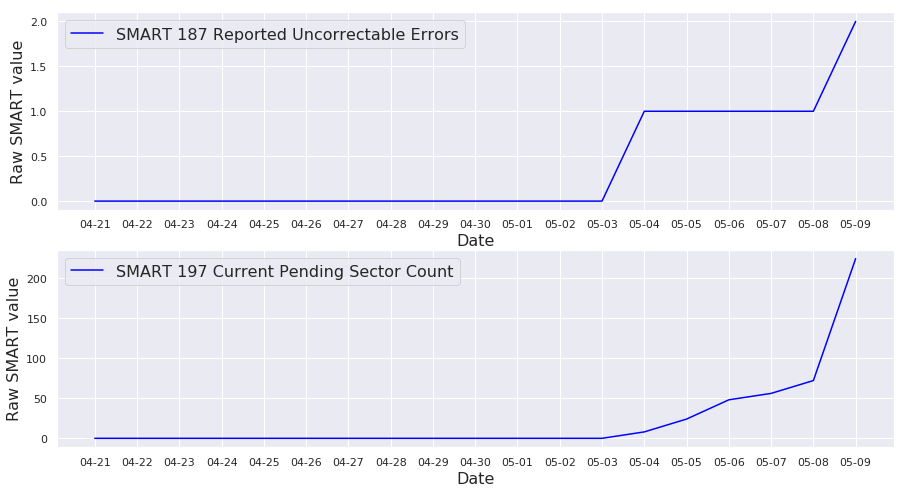

In [10]:
plt.figure(figsize=(15, 8))
col = '#0000ff'

x = fail_stat[SN_1]['date']
y = fail_stat[SN_1]['smart_187_raw']
plt.subplot(2, 1, 1) 
plt.plot(x[::-1], y[::-1], col)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Raw SMART value', fontsize=16)
plt.legend(['SMART 187 Reported Uncorrectable Errors'], fontsize=16)

y = fail_stat[SN_1]['smart_197_raw']
plt.subplot(2, 1, 2)
plt.plot(x[::-1], y[::-1], col)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Raw SMART value', fontsize=16)
plt.legend(['SMART 197 Current Pending Sector Count'], fontsize=16)

Посмотрим историю значений SMART 187 и SMART 5 для диска ZCH083DQ. Судя по графикам ниже, проблемы начались 16-ть дней назад, значение аттрибутов медленно, но непреклонно, шли вверх. Есть выпадение одного дня в статистике (2018-05-03). Можно предположить, что проблемы с диском были замечены и, возможно, его поставили на какие-нибудь тесты, поэтому за этот день он не отображался в статистике центра. В это же время виден скачок смартов; похоже, что предполагаемые тесты значительно ухудшили состояния диска.

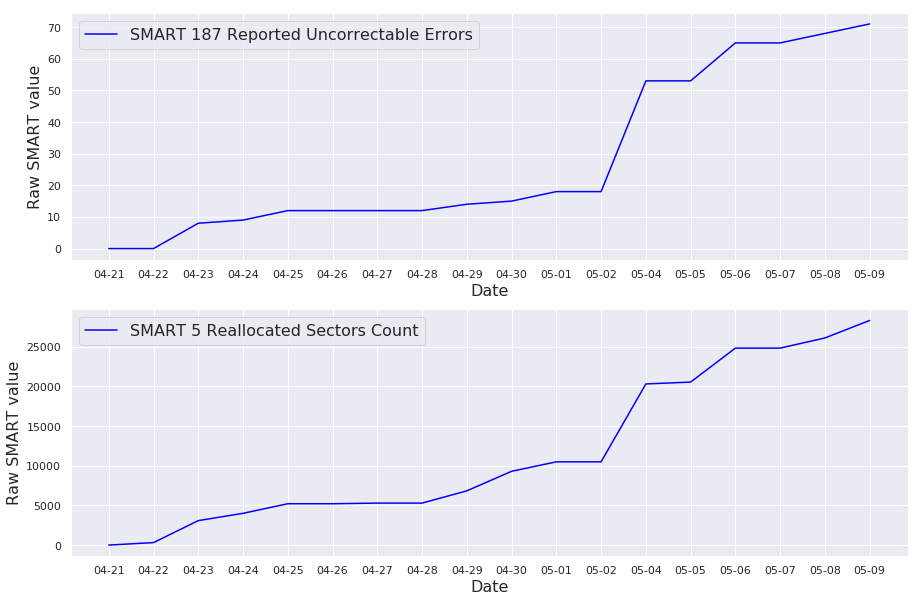

In [11]:
plt.figure(figsize=(15, 10))

x = fail_stat[SN_2]['date']
y = fail_stat[SN_2]['smart_187_raw']
plt.subplot(2, 1, 1) 
plt.plot(x[::-1], y[::-1], col)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Raw SMART value', fontsize=16)
plt.legend(['SMART 187 Reported Uncorrectable Errors'], fontsize=16)

y = fail_stat[SN_2]['smart_5_raw']
plt.subplot(2, 1, 2)
plt.plot(x[::-1], y[::-1], col)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Raw SMART value', fontsize=16)
plt.legend(['SMART 5 Reallocated Sectors Count'], fontsize=16)

## Посмотрим на статистику производителей дисков в целом

Посмотрим сколько различных моделей дисков в дата центрах.

In [12]:
models_stat = base_stat.groupby('model').aggregate({'capacity_bytes': 'sum'}).reset_index()
models_stat

,model,capacity_bytes
0,HGST HDS5C4040ALE630,252049582891008
1,HGST HDS724040ALE640,4000787030016
2,HGST HMS5C4040ALE640,19135764364566528
3,HGST HMS5C4040BLE640,61028005355864064
4,HGST HUH728080ALE600,8361633567006720
5,HGST HUS726040ALE610,104020462780416
6,Hitachi HDS5C4040ALE630,80015740600320
7,Hitachi HDS724040ALE640,8001574060032
8,ST10000NM0086,12201014245457920
9,ST1000LM024 HN,1000204886016


Видно, что есть много моделей дисков одного производителя, объединим их по производителям. Для этого добавим колонку manufacturer, информацию возьмем из колонки model, и найдем общий объем дисков в байтах для каждого производителя.

In [13]:

base_stat['manufacturer'] = base_stat['model']
company = {'^ST.+': 'ST',
           '^WDC WD.+': 'WDC',
           '^TOSHIBA .+': 'TOSHIBA',
           '^HGST .+': 'HGST', 
           '^Hitachi .+': 'Hitachi'}
for reg_exp, company_name in company.items():
    base_stat.replace({'manufacturer' :reg_exp}, {'manufacturer' :company_name}, regex=True, inplace=True)
    
mfg_stat_capacity = base_stat.groupby('manufacturer').aggregate({'capacity_bytes': 'sum'}).reset_index()
mfg_stat_capacity

,manufacturer,capacity_bytes
0,HGST,88885474120138752
1,Hitachi,88017314660352
2,ST,565616282039590912
3,TOSHIBA,1387780242186240
4,WDC,3532846894940160


Посмотрим на долю каждого производителя в суммарном объеме всего центра в процентном соотношении.

In [14]:
mfg_stat_capacity.sort_values(by=['capacity_bytes'], ascending=False, inplace=True)
total_catacity = mfg_stat_capacity.sum()[1]
mfg_stat_capacity.reset_index(drop=True, inplace=True)
mfg_stat_capacity['capacity_bytes'] = mfg_stat_capacity['capacity_bytes'] / total_catacity * 100.
mfg_stat_capacity

,manufacturer,capacity_bytes
0,ST,85.763057
1,HGST,13.477494
2,WDC,0.535677
3,TOSHIBA,0.210426
4,Hitachi,0.013346


Отобразим это на красивом графике. 

Text(0.5, 0, '')

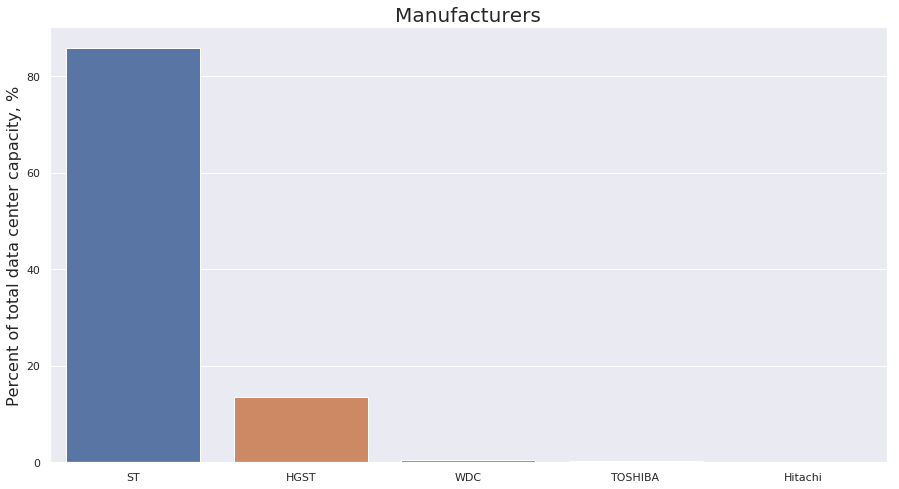

In [15]:
plt.figure(figsize=(15, 8))

plt.title('Manufacturers', fontsize=20)
x = mfg_stat_capacity['manufacturer']
y = mfg_stat_capacity['capacity_bytes']
sns.barplot(x=x, y=y)
plt.ylabel('Percent of total data center capacity, %', fontsize=16)
plt.xlabel('', fontsize=16)

Или не очень красивом графике ... Но видно, что преимущественная доля за Seagate, что не удивительно. 
На pie chart, если приcмотреться можно даже увидеть долю Western Digital.

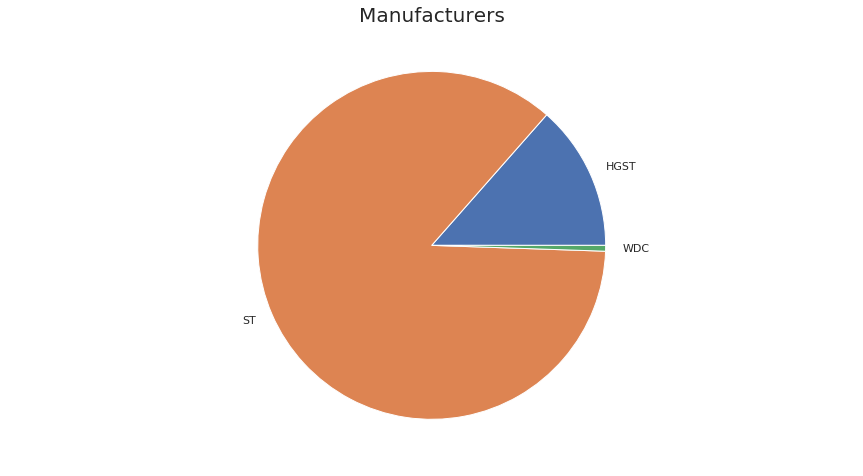

In [16]:
plt.figure(figsize=(15, 8))

plt.title('Manufacturers', fontsize=20)
sums = mfg_stat_capacity.loc[:2,:].capacity_bytes.groupby(mfg_stat_capacity.manufacturer).sum()
plt.axis('equal');
plt.pie(sums, labels=sums.index);
plt.show()

Можно посмотреть распределение производителей по номенклатуре емкостей жестких дисков.

In [17]:
capacity = base_stat['capacity_bytes'].unique()
company = base_stat['manufacturer'].unique()
capacity.sort()
capacity

array([  160041885696,   250059350016,   320072933376,   500107862016,
        1000204886016,  3000592982016,  4000787030016,  5000981078016,
        6001175126016,  8001563222016, 10000831348736, 12000138625024])

In [18]:
enum_capacity_by_company = base_stat.groupby(['capacity_bytes', 'manufacturer']).aggregate({'serial_number': 'count'}).reset_index()
enum_capacity_by_company

,capacity_bytes,manufacturer,serial_number
0,160041885696,ST,11
1,160041885696,WDC,34
2,250059350016,ST,37
3,250059350016,WDC,1
4,320072933376,ST,26
5,320072933376,WDC,3
6,500107862016,ST,630
7,500107862016,TOSHIBA,801
8,500107862016,WDC,359
9,1000204886016,ST,1


Найдем долю в процентах для каждого из производителей жестких дисков по каждой из позиции в номенклатуре дисков по их емкости.

In [19]:
enum_stat = []
for cap in capacity:
    stat_by_capacity = enum_capacity_by_company.loc[enum_capacity_by_company.capacity_bytes == cap, ['serial_number', 'manufacturer']]
    total = stat_by_capacity['serial_number'].sum()
    enum_stat_item = [cap]
    for comp in company:
        by_comp = stat_by_capacity.loc[stat_by_capacity.manufacturer == comp, ['serial_number']].sum()[0]
        enum_stat_item.append(by_comp / total * 100.)
    enum_stat.append(enum_stat_item)
df_enum_stat = pd.DataFrame(enum_stat, columns=['capacity', *company])
df_enum_stat

,capacity,ST,HGST,TOSHIBA,WDC,Hitachi
0,160041885696,24.444444,0.000000,0.000000,75.555556,0.000000
1,250059350016,97.368421,0.000000,0.000000,2.631579,0.000000
2,320072933376,89.655172,0.000000,0.000000,10.344828,0.000000
3,500107862016,35.195531,0.000000,44.748603,20.055866,0.000000
4,1000204886016,100.000000,0.000000,0.000000,0.000000,0.000000
5,3000592982016,0.000000,0.000000,0.000000,100.000000,0.000000
6,4000787030016,59.027918,40.541030,0.294082,0.092656,0.044314
7,5000981078016,0.000000,0.000000,100.000000,0.000000,0.000000
8,6001175126016,80.794413,0.000000,0.130947,19.074640,0.000000
9,8001563222016,95.798982,4.122125,0.078892,0.000000,0.000000


Посмотрим на график распределения для производителя ST, как наиболее широко представленного в рамках данной номенклатуры дисков.

Text(0.5, 1.0, 'ST manufacturer')

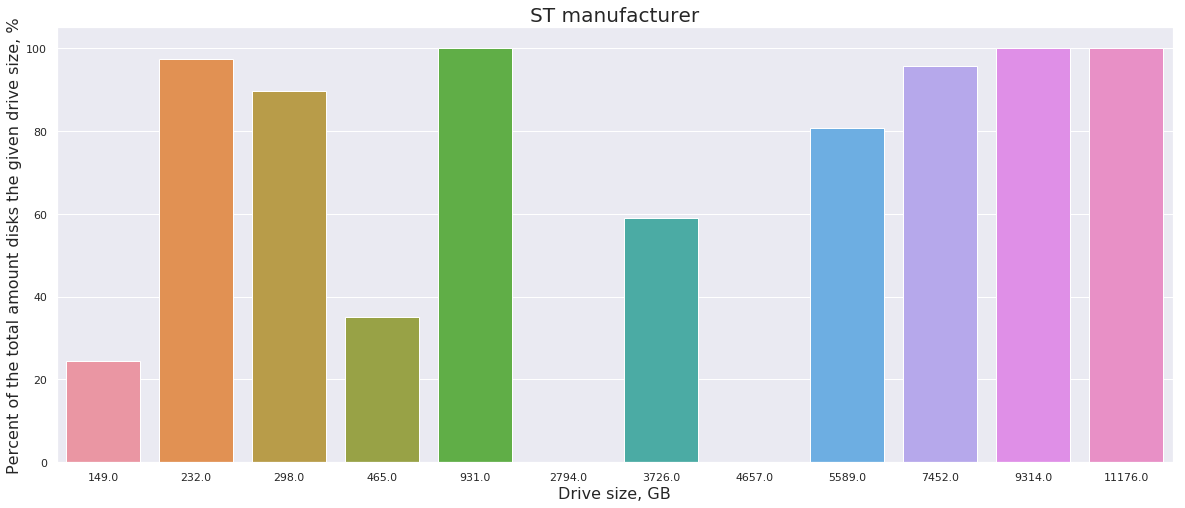

In [20]:
plt.figure(figsize=(20, 8))

x = df_enum_stat['capacity'] / 1024./ 1024. // 1024.
y = df_enum_stat['ST']
sns.barplot(x=x, y=y)
plt.ylabel('Percent of the total amount disks the given drive size, %', fontsize=16)
plt.xlabel('Drive size, GB', fontsize=16)
plt.title('ST manufacturer', fontsize=20)

The End !